## Install & Import Packages

In [ ]:
!pip install sentence_transformers
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install timm fairscale

In [ ]:
import os
import pickle

import clip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode 
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## Load & Preprocess Data

In [3]:
df_train = pd.read_csv("./data/train.tsv", sep="\t")
df_dev = pd.read_csv("./data/dev.tsv", sep="\t")
df_test = pd.read_csv("./data/test.tsv", sep="\t")

# Update image path
df_train["image"] = df_train["image"].apply(lambda s: os.path.join("data", s))
df_dev["image"] = df_dev["image"].apply(lambda s: os.path.join("data", s))
df_test["image"] = df_test["image"].apply(lambda s: os.path.join("data", s))

# Recode label to 0/1
df_train["label"] = df_train["label"].apply(lambda s: 1 if s == "informative" else 0)
df_dev["label"] = df_dev["label"].apply(lambda s: 1 if s == "informative" else 0)
df_test["label"] = df_test["label"].apply(lambda s: 1 if s == "informative" else 0)

## Evaluation

In [4]:
def score(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray) -> None:
    """
    Evaluates the model, printing the accuracy, classification report,
    confusion matrix, ROC curve, and AUC score.

    Args:
        `y_true` (np.ndarray): True labels

        `y_pred` (np.ndarray): Predicted labels
        
        `y_pred_proba` (np.ndarray): Predicted label probabilities

    Usage Example:
        Consider input data `X` of shape (n_samples, n_features), and labels
        `y` of shape (n_samples,).
        >>> from sklearn.linear_model import LogisticRegression
        >>> clf = LogisticRegression(random_state=42)
        >>> clf.fit(X, y)
        >>> y_pred = clf.predict(X)
        >>> y_pred_proba = clf.predict_proba(X)
        >>> score(y, y_pred, y_pred_proba)
    """
    # Accuracy
    print(f"Accuracy: {metrics.accuracy_score(y_true=y_true, y_pred=y_pred)}\n")
        
    # Classification report
    print(metrics.classification_report(y_true=y_true, y_pred=y_pred))

    _, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax1, cmap=plt.cm.Blues, cbar=False)
    ax1.set(xlabel="Pred", ylabel="True", xticklabels=[0, 1], yticklabels=[0, 1], title="Confusion Matrix")

    # ROC curve/AUC score
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred_proba[:, 1], pos_label=1)
    auc_score = metrics.roc_auc_score(y_true=y_true, y_score=y_pred_proba[:, 1])
    ax2.plot(fpr, tpr, color="red", label=f"ROC Curve (AUC = {round(auc_score, 3)})")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("ROC Curve")
    ax2.legend(loc="best")

## Extension 1

We conduct two experiments for extension 1.

### Experiment 1

For the first experiment, we use OpenAI's CLIP model (https://github.com/openai/CLIP) to generate pre-trained text and image embeddings. We then concatenate the embeddings and train an elastic net model with hyperparameter tuning on it to predict `label`.

Load CLIP model.

In [7]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [8]:
def generate_clip_embeddings(
    df: pd.DataFrame, batch_size: int=64
) -> list[list[float]]:
    """
    Generates and concatenates image and text CLIP embeddings for `df`.
    """
    embeddings = []

    for i in tqdm(range(0, len(df), batch_size)):
        image_batch = torch.cat([
            preprocess(Image.open(file_path).convert("RGB")).unsqueeze(0)
            for file_path in df["image"][i : i + batch_size]
        ]).to(device)
        text_batch = clip.tokenize(
            df["tweet_text"][i : i + batch_size], truncate=True
        ).to(device)

        with torch.no_grad():
            image_batch_features = clip_model.encode_image(image_batch)
            text_batch_features = clip_model.encode_text(text_batch)

        embeddings.extend(torch.cat(
            (image_batch_features, text_batch_features), axis=1
        ).tolist())

    return embeddings

Generate and save CLIP embeddings for the train, dev and test data.

In [ ]:
with open("train_clip_embeddings.pkl", mode="wb") as f:
    pickle.dump(generate_clip_embeddings(df_train), f)

with open("dev_clip_embeddings.pkl", mode="wb") as f:
    pickle.dump(generate_clip_embeddings(df_dev), f)

with open("test_clip_embeddings.pkl", mode="wb") as f:
    pickle.dump(generate_clip_embeddings(df_test), f)

Load CLIP embeddings for the train, dev, and test data.

In [26]:
with open("train_clip_embeddings.pkl", mode="rb") as f:
    train_clip_embeddings = pickle.load(f)

with open("dev_clip_embeddings.pkl", mode="rb") as f:
    dev_clip_embeddings = pickle.load(f)

with open("test_clip_embeddings.pkl", mode="rb") as f:
    test_clip_embeddings = pickle.load(f)

Train an elastic net model on the CLIP embeddings to predict `label`, experimenting with different values of `l1_ratio: [0, 0.25, 0.5, 0.75, 1.0]`.

In [89]:
for l1_ratio in [0, 0.25, 0.5, 0.75, 1.0]:
    log_clf_clip = LogisticRegression(penalty="elasticnet", random_state=42, solver="saga", max_iter=1000, l1_ratio=l1_ratio)
    log_clf_clip.fit(train_clip_embeddings, df_train["label"])

    train_y_pred = log_clf_clip.predict(train_clip_embeddings)
    train_accuracy = metrics.accuracy_score(y_true=df_train["label"], y_pred=train_y_pred)
    train_precision, train_recall, train_fscore, _ = metrics.precision_recall_fscore_support(
        y_true=df_train["label"], y_pred=train_y_pred, average="macro"
    )
    print(f"Train | l1_ratio: {l1_ratio} | Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F-Score: {train_fscore}")

    dev_y_pred = log_clf_clip.predict(dev_clip_embeddings)
    dev_accuracy = metrics.accuracy_score(y_true=df_dev["label"], y_pred=dev_y_pred)
    dev_precision, dev_recall, dev_fscore, _ = metrics.precision_recall_fscore_support(
        y_true=df_dev["label"], y_pred=dev_y_pred, average="macro"
    )
    print(f"Dev   | l1_ratio: {l1_ratio} | Accuracy: {dev_accuracy}, Precision: {dev_precision}, Recall: {dev_recall}, F-Score: {dev_fscore}")

Train | l1_ratio: 0 | Accuracy: 0.8288506760728983, Precision: 0.8220604570366821, Recall: 0.8139622198801708, F-Score: 0.8174621740946724
Dev   | l1_ratio: 0 | Accuracy: 0.805543138131426, Precision: 0.7925766909610588, Recall: 0.7878546167612882, F-Score: 0.7900325924775138
Train | l1_ratio: 0.25 | Accuracy: 0.8292915931804821, Precision: 0.8226595008150521, Recall: 0.814216931435041, F-Score: 0.8178466961306472
Dev   | l1_ratio: 0.25 | Accuracy: 0.8046490835940993, Precision: 0.7917541150917227, Recall: 0.7864027538726334, F-Score: 0.7888448848448848
Train | l1_ratio: 0.5 | Accuracy: 0.8292181069958847, Precision: 0.8226109492566824, Recall: 0.8140870148846012, F-Score: 0.8177467804881389
Dev   | l1_ratio: 0.5 | Accuracy: 0.8037550290567724, Precision: 0.7907784436361098, Recall: 0.7854449782070714, F-Score: 0.7878784998784998
Train | l1_ratio: 0.75 | Accuracy: 0.8292181069958847, Precision: 0.8225902877900406, Recall: 0.8141220007344525, F-Score: 0.8177611182745336
Dev   | l1_ratio

`l1_ratio = 0` marginally yields the best dev accuracy and f-score. Retrain the model using this hyperparameter and evaluate it on the train data.

Accuracy: 0.8288506760728983

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      5267
           1       0.85      0.88      0.86      8341

    accuracy                           0.83     13608
   macro avg       0.82      0.81      0.82     13608
weighted avg       0.83      0.83      0.83     13608



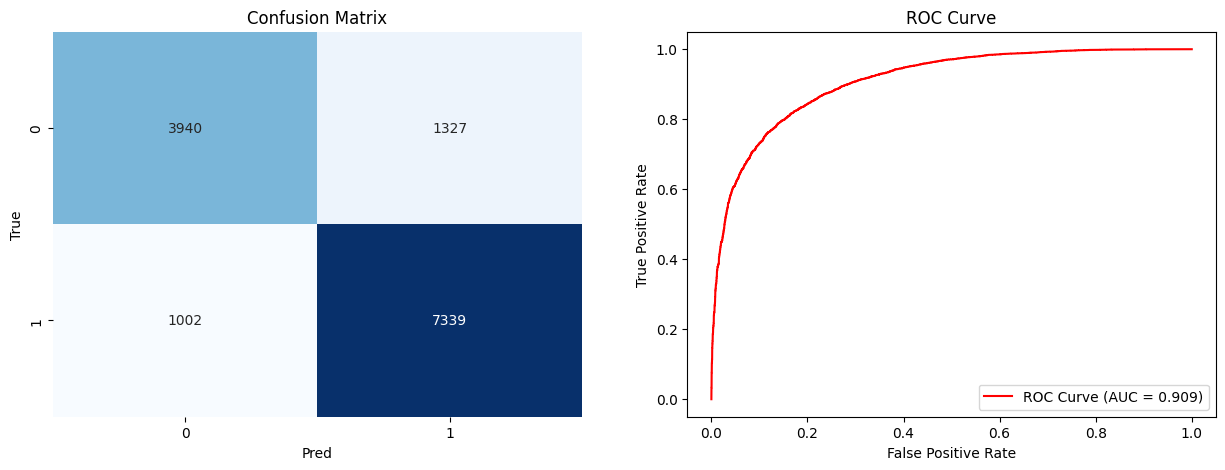

In [90]:
log_clf_clip = LogisticRegression(penalty="elasticnet", random_state=42, solver="saga", max_iter=1000, l1_ratio=0)
log_clf_clip.fit(train_clip_embeddings, df_train["label"])

score(
    df_train["label"],
    log_clf_clip.predict(train_clip_embeddings),
    log_clf_clip.predict_proba(train_clip_embeddings)
)

Evaluate the model on the dev data.

Accuracy: 0.805543138131426

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       830
           1       0.84      0.86      0.85      1407

    accuracy                           0.81      2237
   macro avg       0.79      0.79      0.79      2237
weighted avg       0.80      0.81      0.80      2237



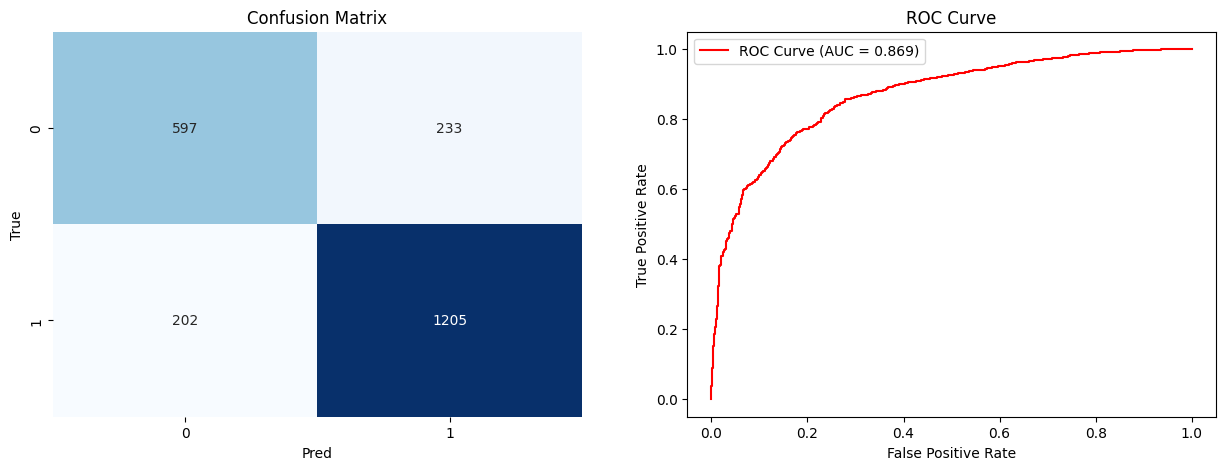

In [91]:
score(
    df_dev["label"],
    log_clf_clip.predict(dev_clip_embeddings),
    log_clf_clip.predict_proba(dev_clip_embeddings)
)

Evaluate the model on the test data.

Accuracy: 0.7845328565042468

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       864
           1       0.81      0.84      0.83      1373

    accuracy                           0.78      2237
   macro avg       0.77      0.77      0.77      2237
weighted avg       0.78      0.78      0.78      2237



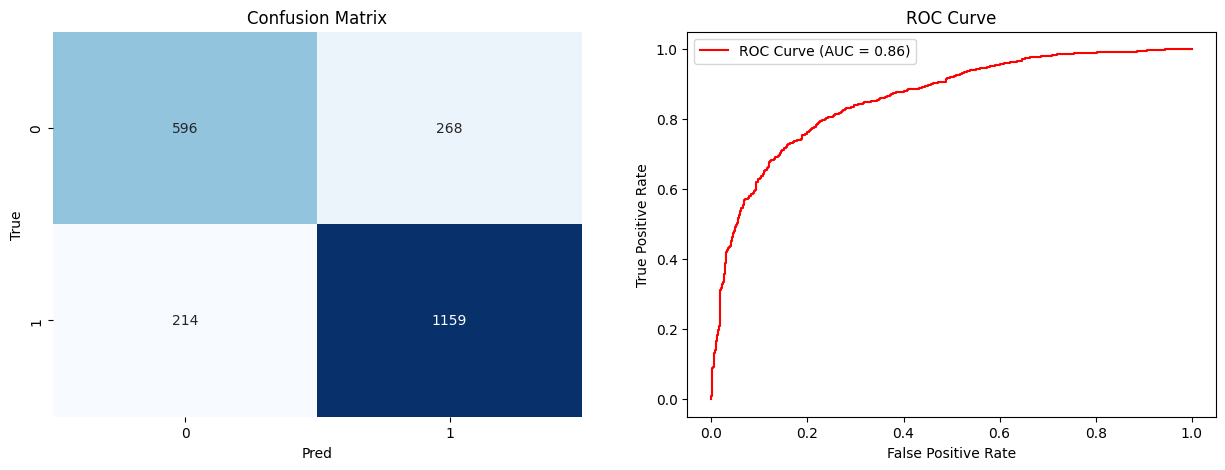

In [92]:
score(
    df_test["label"],
    log_clf_clip.predict(test_clip_embeddings),
    log_clf_clip.predict_proba(test_clip_embeddings)
)

### Experiment 2

For the second experiment we use Salesforce's BLIP model (https://github.com/salesforce/BLIP) to generate image captions. We then augment the tweet text using the image captions and generate sentence-transformers (https://www.sbert.net/) embeddings for the augmented text. Finally, we train an elastic net model with hyperparameter tuning on it to predict `label`.

In [ ]:
!git clone https://github.com/salesforce/BLIP

In [ ]:
cd BLIP

Load BLIP model.

In [ ]:
from models.blip import blip_decoder

blip_model = blip_decoder(
    pretrained="https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth",
    image_size=384,
    vit="base"
).to(device)

blip_model.eval()

In [17]:
transform = transforms.Compose([
    transforms.Resize((384, 384),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor()
])

def generate_blip_captions(df: pd.DataFrame, batch_size: int=64) -> list[str]:
    """
    Generates BLIP image captions for `df`.
    """
    captions = []

    for i in tqdm(range(0, len(df), batch_size)):
        image_batch = torch.cat([
            transform(Image.open(file_path).convert("RGB")).unsqueeze(0)
            for file_path in df["image"][i : i + batch_size].apply(
                lambda s: os.path.join("..", s)
            ).tolist()
        ]).to(device)

        with torch.no_grad():
            captions.extend(blip_model.generate(
                image_batch,
                sample=True,
                top_p=0.9,
                max_length=20,
                min_length=5
            ))

    return captions

Generate and save image captions.

In [ ]:
df_train["image_caption"] = generate_blip_captions(df_train)
df_train.to_csv("../train_with_captions.csv", index=False)

df_dev["image_caption"] = generate_blip_captions(df_dev)
df_dev.to_csv("../dev_with_captions.csv", index=False)

df_test["image_caption"] = generate_blip_captions(df_test)
df_test.to_csv("../test_with_captions.csv", index=False)

In [ ]:
cd ..

Load dataframes with image captions and augment the text. Given a `(tweet_text, image_caption)` pair, we augment the text as `Tweet: {tweet_text}\nImage Caption: {image_caption}`.

In [75]:
df_train_with_captions = pd.read_csv("train_with_captions.csv")
df_dev_with_captions = pd.read_csv("dev_with_captions.csv")
df_test_with_captions = pd.read_csv("test_with_captions.csv")

df_train_with_captions["tweet_text_with_captions"] = df_train_with_captions.apply(
    lambda row: f"Tweet: {row['tweet_text']}\nImage Caption: {row['image_caption']}", axis=1)
df_dev_with_captions["tweet_text_with_captions"] = df_dev_with_captions.apply(
    lambda row: f"Tweet: {row['tweet_text']}\nImage Caption: {row['image_caption']}", axis=1)
df_test_with_captions["tweet_text_with_captions"] = df_test_with_captions.apply(
    lambda row: f"Tweet: {row['tweet_text']}\nImage Caption: {row['image_caption']}", axis=1)

Load sentence-transformer model.

In [76]:
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

Generate and save sentence-transformer embeddings for the augmented text for the train, dev, and test data.

In [84]:
with open("train_with_captions_sbert_embeddings.pkl", mode="wb") as f:
    pickle.dump(sentence_transformer.encode(
        df_train_with_captions["tweet_text_with_captions"], device=device
    ), f)

with open("dev_with_captions_sbert_embeddings.pkl", mode="wb") as f:
    pickle.dump(sentence_transformer.encode(
        df_dev_with_captions["tweet_text_with_captions"], device=device
    ), f)

with open("test_with_captions_sbert_embeddings.pkl", mode="wb") as f:
    pickle.dump(sentence_transformer.encode(
        df_test_with_captions["tweet_text_with_captions"], device=device
    ), f)

Load sentence-transformer embeddings for the train, dev, and test data.

In [85]:
with open("train_with_captions_sbert_embeddings.pkl", mode="rb") as f:
    train_sbert_embeddings = pickle.load(f)

with open("dev_with_captions_sbert_embeddings.pkl", mode="rb") as f:
    dev_sbert_embeddings = pickle.load(f)

with open("test_with_captions_sbert_embeddings.pkl", mode="rb") as f:
    test_sbert_embeddings = pickle.load(f)

Train an elastic net model on the sentence-bert embeddings to predict `label`, experimenting with different values of `l1_ratio: [0, 0.25, 0.5, 0.75, 1.0]`.

In [93]:
for l1_ratio in [0, 0.25, 0.5, 0.75, 1.0]:
    log_clf_sbert = LogisticRegression(penalty="elasticnet", random_state=42, solver="saga", max_iter=1000, l1_ratio=l1_ratio)
    log_clf_sbert.fit(train_sbert_embeddings, df_train_with_captions["label"])

    train_y_pred = log_clf_sbert.predict(train_sbert_embeddings)
    train_accuracy = metrics.accuracy_score(y_true=df_train_with_captions["label"], y_pred=train_y_pred)
    train_precision, train_recall, train_fscore, _ = metrics.precision_recall_fscore_support(
        y_true=df_train_with_captions["label"], y_pred=train_y_pred, average="macro"
    )
    print(f"Train | l1_ratio: {l1_ratio} | Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F-Score: {train_fscore}")

    dev_y_pred = log_clf_sbert.predict(dev_sbert_embeddings)
    dev_accuracy = metrics.accuracy_score(y_true=df_dev_with_captions["label"], y_pred=dev_y_pred)
    dev_precision, dev_recall, dev_fscore, _ = metrics.precision_recall_fscore_support(
        y_true=df_dev_with_captions["label"], y_pred=dev_y_pred, average="macro"
    )
    print(f"Dev   | l1_ratio: {l1_ratio} | Accuracy: {dev_accuracy}, Precision: {dev_precision}, Recall: {dev_recall}, F-Score: {dev_fscore}")

Train | l1_ratio: 0 | Accuracy: 0.7827748383303939, Precision: 0.7776375760661479, Recall: 0.7557701329054847, F-Score: 0.7627880931903448
Dev   | l1_ratio: 0 | Accuracy: 0.7590523021904336, Precision: 0.745644424807589, Recall: 0.7247099271285569, F-Score: 0.7315508159499928
Train | l1_ratio: 0.25 | Accuracy: 0.7831422692533804, Precision: 0.7780720448404652, Recall: 0.7561398288588739, F-Score: 0.7631782969805911
Dev   | l1_ratio: 0.25 | Accuracy: 0.7563701385784533, Precision: 0.7421588812908755, Recall: 0.72257773096651, F-Score: 0.7290785985725996
Train | l1_ratio: 0.5 | Accuracy: 0.7828483245149912, Precision: 0.7776793275041374, Recall: 0.7559000494559245, F-Score: 0.7629014653430296
Dev   | l1_ratio: 0.5 | Accuracy: 0.7550290567724631, Precision: 0.740650663474233, Recall: 0.7210175456623937, F-Score: 0.7275012403726631
Train | l1_ratio: 0.75 | Accuracy: 0.7826278659611993, Precision: 0.7773015114996775, Recall: 0.7558251724532663, F-Score: 0.7627600241457202
Dev   | l1_ratio: 

`l1_ratio = 0` marginally yields the best dev accuracy and f-score. Retrain the model using this hyperparameter and evaluate it on the train data.

Accuracy: 0.7827748383303939

              precision    recall  f1-score   support

           0       0.76      0.64      0.69      5267
           1       0.79      0.88      0.83      8341

    accuracy                           0.78     13608
   macro avg       0.78      0.76      0.76     13608
weighted avg       0.78      0.78      0.78     13608



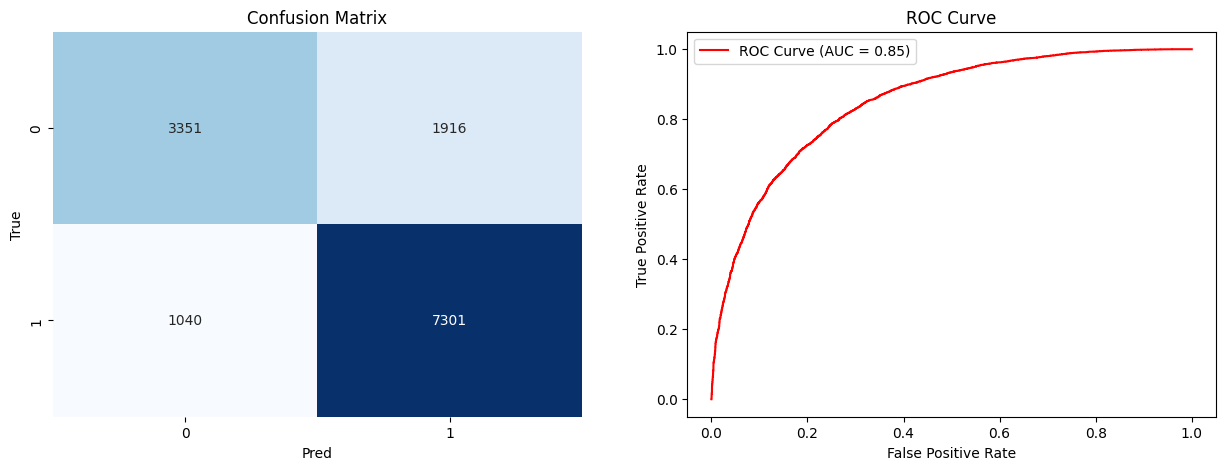

In [96]:
log_clf_sbert = LogisticRegression(penalty="elasticnet", random_state=42, solver="saga", max_iter=1000, l1_ratio=0)
log_clf_sbert.fit(train_sbert_embeddings, df_train_with_captions["label"])

score(
    df_train_with_captions["label"],
    log_clf_sbert.predict(train_sbert_embeddings),
    log_clf_sbert.predict_proba(train_sbert_embeddings)
)

Evaluate the model on the dev data.

Accuracy: 0.7590523021904336

              precision    recall  f1-score   support

           0       0.71      0.59      0.65       830
           1       0.78      0.86      0.82      1407

    accuracy                           0.76      2237
   macro avg       0.75      0.72      0.73      2237
weighted avg       0.75      0.76      0.75      2237



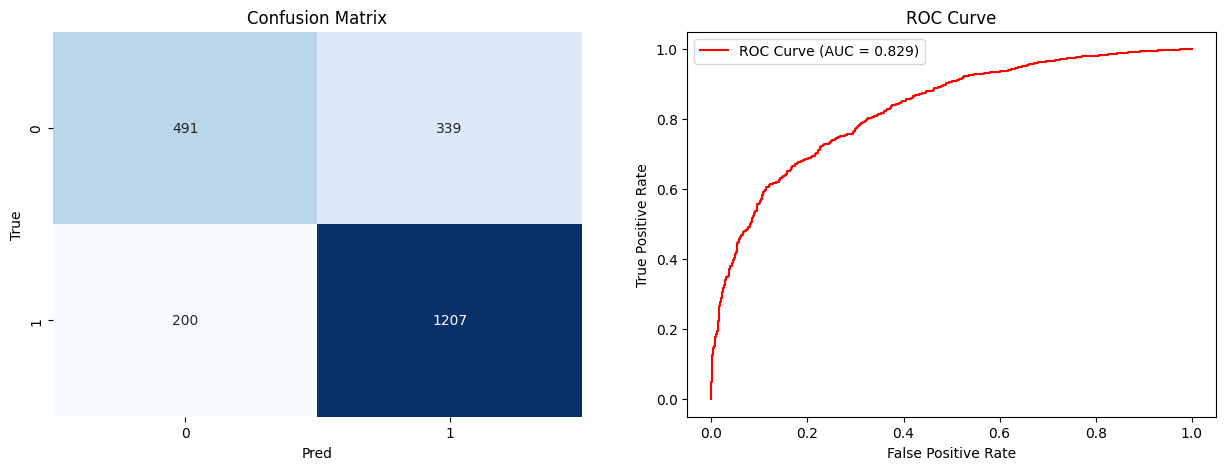

In [97]:
score(
    df_dev_with_captions["label"],
    log_clf_sbert.predict(dev_sbert_embeddings),
    log_clf_sbert.predict_proba(dev_sbert_embeddings)
)

Evaluate the model on the test data.

Accuracy: 0.7657577112203845

              precision    recall  f1-score   support

           0       0.74      0.61      0.67       864
           1       0.78      0.86      0.82      1373

    accuracy                           0.77      2237
   macro avg       0.76      0.74      0.74      2237
weighted avg       0.76      0.77      0.76      2237



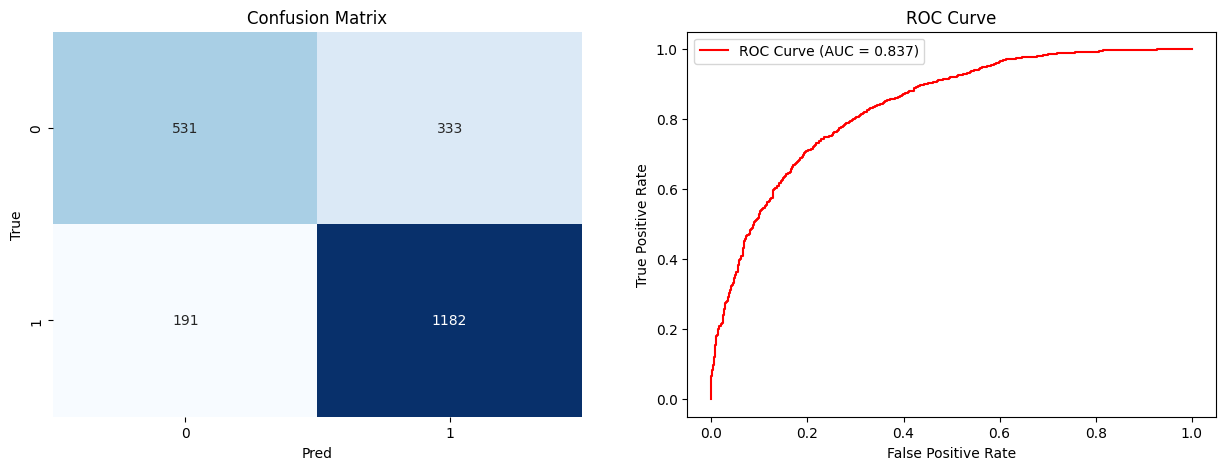

In [98]:
score(
    df_test_with_captions["label"],
    log_clf_sbert.predict(test_sbert_embeddings),
    log_clf_sbert.predict_proba(test_sbert_embeddings)
)